# Model 1: Convolution 1D

_Bastien Leduc - A20520860_\
_Paul Legout - A20522029_

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
import matplotlib.pyplot as plt

import tensorflow as tf
from keras import models, layers

import preprocessing
from resources import *

from sklearn.utils import shuffle

Some useful paths

In [2]:
DIR_DATA = "../../data"
DIR_ANNOTATIONS = DIR_DATA + "/annotations"
DIR_IMAGES = DIR_DATA + "/.data"

### Load data

In [3]:
# Load data, without bbox coordinates (just landmarks)
x, y, num_landmarks, labels = preprocessing.load_data(DIR_ANNOTATIONS, bbox=False)

In [91]:
x.shape

(498450, 21, 2)

In [92]:
y.shape

(498450,)

In [4]:
# Total number of elements
dataset_size = len(x)
dataset_size

498450

In [69]:
x[0]

array([[0.48577094, 0.34269387],
       [0.5131875 , 0.33229622],
       [0.52744323, 0.31933323],
       [0.54084665, 0.30919853],
       [0.5501136 , 0.29903787],
       [0.49674368, 0.29265848],
       [0.49717882, 0.27431828],
       [0.49990204, 0.25986278],
       [0.50098747, 0.2479173 ],
       [0.4900852 , 0.29187092],
       [0.5300984 , 0.28509277],
       [0.5429096 , 0.30041355],
       [0.5414515 , 0.31114858],
       [0.48896438, 0.29569817],
       [0.52976036, 0.2975562 ],
       [0.53184247, 0.31377736],
       [0.52209437, 0.3217564 ],
       [0.49241036, 0.30190116],
       [0.52629584, 0.3048785 ],
       [0.52651304, 0.31526285],
       [0.51605254, 0.32006243]], dtype=float32)

In [5]:
num_labels = len(labels)

### Prepare and split data

One-hot-encoding

In [94]:
# Available labels
labels

array(['call', 'dislike', 'fist', 'four', 'like', 'mute', 'no_gesture',
       'ok', 'one', 'palm', 'peace', 'peace_inverted', 'rock', 'stop',
       'stop_inverted', 'three', 'three2', 'two_up', 'two_up_inverted'],
      dtype='<U15')

In [6]:
encoder = OneHotEncoder(sparse_output=False)

y = encoder.fit_transform(y.reshape(-1, 1))

In [96]:
y.shape

(498450, 19)

70% training, 10% validation and 20% test

In [7]:
train_perc = 0.7
test_perc = 0.2
val_perc = 0.1


x, y = shuffle(x, y)

In [8]:

x_train = x[: int(train_perc * dataset_size)]
y_train = y[: int(train_perc * dataset_size)]

x_test = x[int(train_perc * dataset_size): int((train_perc + test_perc) * dataset_size) ]
y_test = y[int(train_perc * dataset_size): int((train_perc + test_perc) * dataset_size) ]

x_val = x[int((train_perc + test_perc) * dataset_size): ]
y_val = y[int((train_perc + test_perc) * dataset_size): ]

### Model

In [121]:
def create_model(shape):
	input_tensor = layers.Input(shape=shape)

	#################### Feature extraction ####################

	x = layers.Conv1D(filters=16, kernel_size=5, strides=1, padding="same")(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.MaxPooling1D(pool_size=3, strides=1)(x)

	x = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="same")(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.MaxPooling1D(pool_size=3, strides=1)(x)
	
	
	x = layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same")(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.MaxPooling1D(pool_size=3, strides=1)(x)

	
	#################### Classification ####################	

	x = layers.Flatten()(x)
	output_tensor = layers.Dense(num_labels, activation="softmax")(x)

	return models.Model(inputs=[input_tensor], outputs=[output_tensor])

In [122]:
model = create_model(shape=x[0].shape)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 21, 2)]           0         
                                                                 
 conv1d_24 (Conv1D)          (None, 21, 16)            176       
                                                                 
 batch_normalization_24 (Bat  (None, 21, 16)           64        
 chNormalization)                                                
                                                                 
 activation_24 (Activation)  (None, 21, 16)            0         
                                                                 
 max_pooling1d_24 (MaxPoolin  (None, 19, 16)           0         
 g1D)                                                            
                                                                 
 conv1d_25 (Conv1D)          (None, 19, 32)            2592

In [ ]:
hist = compile_and_fit(
    model,
    x_train,
    y_train,
    validation_data=(x_val, y_val),
	max_epochs=100,
    run_on_gpu=False
)

save_model(model, "model_conv1d")

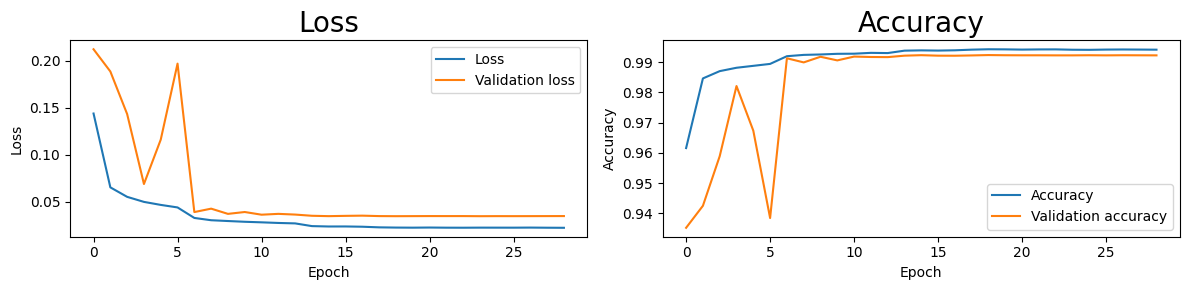

In [124]:
plot(hist)

In [10]:
predictions_summary("model_conv1d", x_test, y_test, labels, run_on_gpu=False)

2023-04-09 14:38:22.899708: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-09 14:38:34.783009: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Loss: 0.024833479896187782
Accuracy: 99.384%

Precision: 99.387%
Recall: 99.391%
F1-Score: 99.389%

Min: 7.758509e-37
Mean: 0.052631583
Max: 1.0

--------------------- Confusion Matrix ---------------------

True call (5178)
Predicted: 5156 (call) ---- 1 (dislike) ---- 13 (like) ---- 4 (no_gesture) ---- 1 (one) ---- 1 (rock) ---- 1 (stop) ---- 1 (two_up_inverted)

True dislike (5013)
Predicted: 5000 (dislike) ---- 2 (fist) ---- 1 (mute) ---- 6 (no_gesture) ---- 2 (peace_inverted) ---- 1 (stop_inverted) ---- 1 (two_up_inverted)

True fist (4917)
Predicted: 1 (call) ---- 2 (dislike) ---- 4892 (fist) ---- 1 (four) ---- 2 (like) ---- 5 (mute) ---- 6 (no_gesture) ---- 6 (one) ---- 1 (rock) ---- 1 (stop) ---- 

True four (5164)
Predicted: 1 (fist) ---- 5150 (four) ---- 1 (mute) ---- 1 (no_gesture) ---- 5 (palm) ---- 1 (peace) ---- 2 (rock) ---- 1 (stop_inverted) ---- 2 (three) ---- 

True like (4848)
Predicted: 6 (call) ---- 1 (dislike) ---- 4 (fist) ---- 4821 (like) ---- 14 (no_gesture) ---

### Full convolutional network

In [11]:
def create_model_full_conv(shape, output_dim: int):
	input_tensor = layers.Input(shape=shape)

	#################### Feature extraction ####################

	x = layers.Conv1D(filters=16, kernel_size=5, strides=1, padding="same")(input_tensor)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.MaxPooling1D(pool_size=3, strides=1)(x)

	x = layers.Conv1D(filters=32, kernel_size=5, strides=1, padding="same")(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.MaxPooling1D(pool_size=3, strides=1)(x)
	
	
	x = layers.Conv1D(filters=64, kernel_size=5, strides=1, padding="same")(x)
	x = layers.BatchNormalization()(x)
	x = layers.Activation("relu")(x)
	x = layers.MaxPooling1D(pool_size=3, strides=1)(x)

	
	#################### Classification ####################	

	output_tensor = layers.Conv1D(output_dim, kernel_size=x.shape[1], activation="softmax")(x)
	output_tensor = layers.Reshape(target_shape=(output_dim,))(output_tensor)

	return models.Model(inputs=[input_tensor], outputs=[output_tensor])

In [16]:
model_full_conv = create_model_full_conv(shape=x[0].shape, output_dim=num_labels)
model_full_conv.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 21, 2)]           0         
                                                                 
 conv1d_12 (Conv1D)          (None, 21, 16)            176       
                                                                 
 batch_normalization_9 (Batc  (None, 21, 16)           64        
 hNormalization)                                                 
                                                                 
 activation_9 (Activation)   (None, 21, 16)            0         
                                                                 
 max_pooling1d_9 (MaxPooling  (None, 19, 16)           0         
 1D)                                                             
                                                                 
 conv1d_13 (Conv1D)          (None, 19, 32)            2592

In [ ]:
hist_full_conv = compile_and_fit(
    model_full_conv,
    x_train,
    y_train,
    validation_data=(x_val, y_val),
	max_epochs=100,
    run_on_gpu=False
)

save_model(model_full_conv, "model_full_conv1d")

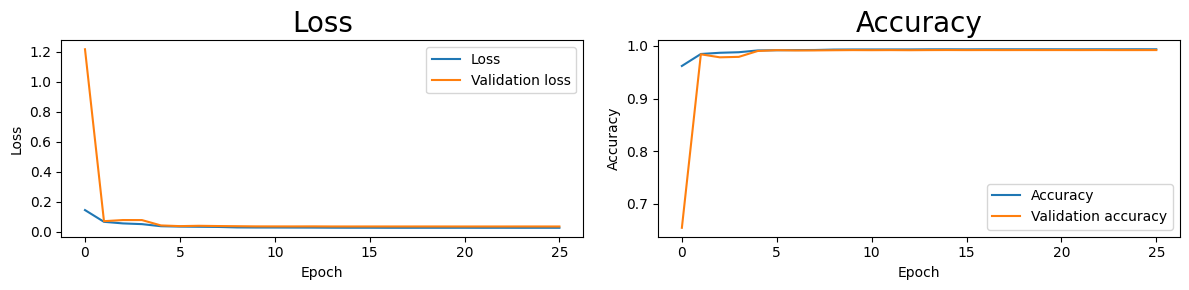

In [18]:
plot(hist_full_conv)

In [19]:
predictions_summary("model_full_conv1d", x_test, y_test, labels, run_on_gpu=False)

2023-04-10 00:40:53.742806: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-04-10 00:41:22.636459: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Loss: 0.0367853119969368
Accuracy: 99.179%

Precision: 99.177%
Recall: 99.187%
F1-Score: 99.182%

Min: 0.0
Mean: 0.05263158
Max: 1.0

--------------------- Confusion Matrix ---------------------

True call (4947)
Predicted: 4908 (call) ---- 28 (like) ---- 2 (mute) ---- 4 (no_gesture) ---- 1 (rock) ---- 1 (stop) ---- 3 (stop_inverted) ---- 

True dislike (5015)
Predicted: 1 (call) ---- 4981 (dislike) ---- 2 (fist) ---- 5 (like) ---- 4 (mute) ---- 13 (no_gesture) ---- 1 (peace_inverted) ---- 1 (stop) ---- 1 (stop_inverted) ---- 1 (three2) ---- 5 (two_up_inverted)

True fist (4935)
Predicted: 2 (dislike) ---- 4915 (fist) ---- 1 (four) ---- 2 (like) ---- 2 (mute) ---- 3 (no_gesture) ---- 7 (one) ---- 1 (stop) ---- 1 (stop_inverted) ---- 1 (two_up) ---- 

True four (5247)
Predicted: 1 (fist) ---- 5223 (four) ---- 2 (no_gesture) ---- 1 (ok) ---- 6 (palm) ---- 1 (peace_inverted) ---- 2 (rock) ---- 4 (stop) ---- 2 (stop_inverted) ---- 5 (three) ---- 

True like (4896)
Predicted: 7 (call) ---- 

### Average time to make a prediction

In [32]:
import time
from random import randint

In [35]:
num_iters = 2000
count = 0

for i in range(num_iters):
	index = randint(0, x_test.shape[0] - 1)

	start = time.time()

	with tf.device('CPU'):
		model_full_conv.predict(x_test[index].reshape(1, num_landmarks, 2), verbose=False)

	count += time.time() - start

print(f"Average time: {round(count / num_iters, 4)} seconds")

Average time: 0.0348 seconds
